In [34]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [35]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [36]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-12-21 09:54:49--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2020-12-21 09:54:49 (8.60 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



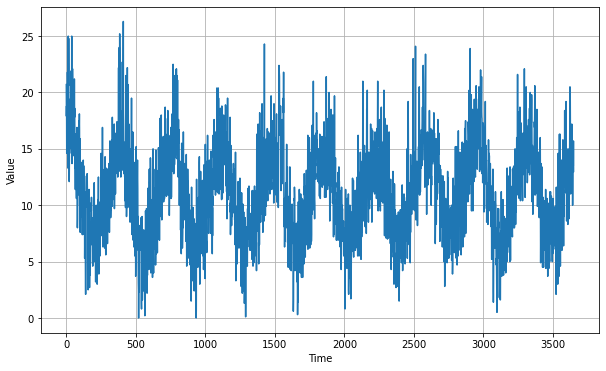

In [37]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  temp_reader = csv.reader(csvfile, delimiter = ',')
  next(temp_reader)
  step = 0
  for row in temp_reader:
    time_step.append(step)
    temps.append(float(row[1]))
    step += 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [38]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda x : x.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x : (x[:-1], x[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
 def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 3s 20ms/step - loss: 12.5094 - mae: 13.0067
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 12.1438 - mae: 12.6406
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - loss: 11.7306 - mae: 12.2265
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 11.2720 - mae: 11.7673
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 10.7201 - mae: 11.2138
Epoch 6/100
10/10 [==============================] - 0s 27ms/step - loss: 10.1547 - mae: 10.6476
Epoch 7/100
10/10 [==============================] - 0s 28ms/step - loss: 9.5155 - mae: 10.0070
Epoch 8/100
10/10 [==============================] - 0s 28ms/step - loss: 9.1105 - mae: 9.6007
Epoch 9/100
10/10 [==============================] - 0s 28ms/step - loss: 8.7271 - mae: 9.2160
Epoch 10/100
10/10 [==========

(1e-08, 0.0001, 0.0, 60.0)

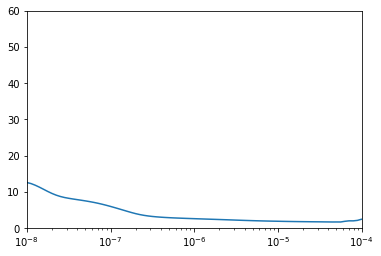

In [45]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=80, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),               
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 300)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
19/19 [==============================] - 3s 17ms/step - loss: 10.6318 - mae: 11.1173
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 2.4482 - mae: 2.9119
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 1.9259 - mae: 2.3787
Epoch 4/100
19/19 [==============================] - 1s 20ms/step - loss: 1.7916 - mae: 2.2423
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 1.7578 - mae: 2.2073
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 1.7344 - mae: 2.1841
Epoch 7/100
19/19 [==============================] - 1s 21ms/step - loss: 1.7141 - mae: 2.1636
Epoch 8/100
19/19 [==============================] - 1s 21ms/step - loss: 1.7001 - mae: 2.1486
Epoch 9/100
19/19 [==============================] - 1s 20ms/step - loss: 1.6983 - mae: 2.1468
Epoch 10/100
19/19 [==============================] - 0s 19ms/step - loss: 1.6787 - mae: 2.1268
Epoch 11/100
19/19 [===========================

In [59]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

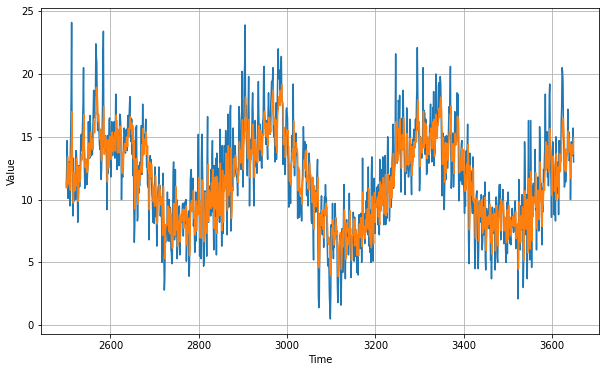

In [60]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.785331